In [2]:
import pandas as pd

In [3]:
# Path to the CSV file
csvFile = 'data/open-meteo-43.69N7.19E17m.csv'

# Read the CSV file using pandas
data = pd.read_csv(csvFile)


In [5]:
data.dropna(inplace=True)
data['time'] = data['time'].str.replace('T', ' ')
data.rename(columns={'temperature_2m (°C)': 'temperature'}, inplace=True)
data.rename(columns={'wind_speed_10m (km/h)': 'wind_speed'}, inplace=True)
data.rename(columns={'wind_direction_10m (°)': 'wind_direction'}, inplace=True)
print(data)

                  time  wind_speed  wind_direction
0     2024-01-01 00:00         8.6           285.0
1     2024-01-01 01:00         9.0           299.0
2     2024-01-01 02:00        11.1           299.0
3     2024-01-01 03:00        14.0           314.0
4     2024-01-01 04:00        14.6           320.0
...                ...         ...             ...
3861  2024-06-09 21:00         8.1            21.0
3862  2024-06-09 22:00         1.1           162.0
3863  2024-06-09 23:00         3.2           207.0
3864  2024-06-10 00:00         3.4           252.0
3865  2024-06-10 01:00         3.1           339.0

[3866 rows x 3 columns]


In [4]:
# Convert 'time' column to datetime format
data['time'] = pd.to_datetime(data['time'])

# Split data into dataframes for months
data_by_month = data.groupby(data['time'].dt.month)

# Split each month's data into dataframes for days
data_by_month_and_day = {}
for month, month_data in data_by_month:
    data_by_month_and_day[month] = month_data.groupby(month_data['time'].dt.day)

# Access dataframes for each month and day
for month, month_data in data_by_month_and_day.items():
    print(f"Month: {month}")
    for day, day_data in month_data:
        print(f"Day: {day}")
        print(day_data)
        print()

Month: 1
Day: 1
                  time  temperature
0  2024-01-01 00:00:00          8.7
1  2024-01-01 01:00:00          8.5
2  2024-01-01 02:00:00          7.4
3  2024-01-01 03:00:00          8.1
4  2024-01-01 04:00:00          7.6
5  2024-01-01 05:00:00          7.1
6  2024-01-01 06:00:00          7.2
7  2024-01-01 07:00:00          6.9
8  2024-01-01 08:00:00          6.8
9  2024-01-01 09:00:00          6.5
10 2024-01-01 10:00:00          7.0
11 2024-01-01 11:00:00          8.9
12 2024-01-01 12:00:00         11.0
13 2024-01-01 13:00:00         12.2
14 2024-01-01 14:00:00         12.9
15 2024-01-01 15:00:00         13.0
16 2024-01-01 16:00:00         12.4
17 2024-01-01 17:00:00         11.5
18 2024-01-01 18:00:00          8.3
19 2024-01-01 19:00:00          7.7
20 2024-01-01 20:00:00          7.3
21 2024-01-01 21:00:00          6.7
22 2024-01-01 22:00:00          4.6
23 2024-01-01 23:00:00          4.4

Day: 2
                  time  temperature
24 2024-01-02 00:00:00          4.7
25 2

# Wind

In [6]:
import sympy as sp
import math
import numpy as np

t = np.linspace(0, 10) # hours
wd = data['wind_direction'] # degrees
ws = data['wind_speed'] # km/h

cable_length = 100 # m
cable_radius = 0.01 # m

cD = 0.5 # drag coefficient -- for a cylinder #! will differ for different cables

air_density =  1.229 # kg/m^3 -- at sea level

def area_hit(wind_angle):
    return 2 * np.pi * cable_radius * cable_length * np.cos(wind_angle * np.pi / 180) # m^2 #! assume 0 degrees means wind is perpendicular to the cable

mass_of_air = air_density * area_hit(wd) * ws**2 * cable_length # kg

F = 1/2 * air_density * ws**2 * area_hit(wd) * cD # N

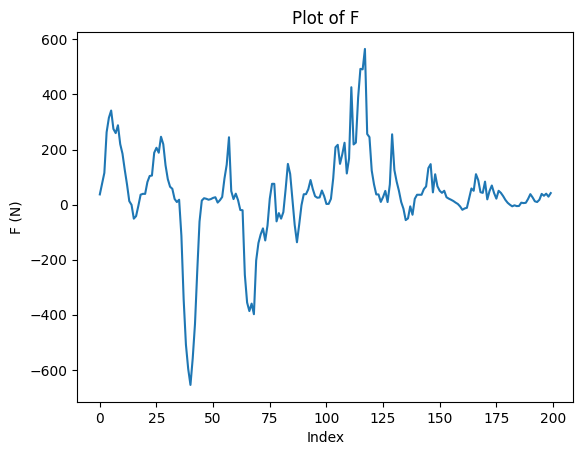

In [10]:
import matplotlib.pyplot as plt

plt.plot(F[:200])
plt.xlabel('Index')
plt.ylabel('F (N)')
plt.title('Plot of F')
plt.show()

# LIB TEST

In [1]:
from environment.models.weather_control_fixed import WeatherControlledFixedEnv